<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/sensitivity-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
import joblib
import pickle
import os

import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# If downloading from GitHub, these paths will not work.
repo_path = '/content/drive/MyDrive/milestone-ii/'
train_path = ''.join([repo_path, 'Training_set.csv'])
test_path = ''.join([repo_path, 'Testing_set.csv'])

df_train = pd.read_csv(train_path, sep='\t', index_col='ix')
df_train['lemmatized_text'] = df_train['lemmatized_text'].fillna('')
df_test = pd.read_csv(test_path, sep='\t', index_col='ix')
df_test['lemmatized_text'] = df_test['lemmatized_text'].fillna('')

df = pd.concat([df_train, df_test])
df.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,there be manuscript evidence that austen conti...,8.236551,5.809310,3.57,12.12,2.495517,1.33,4.57,37.0,1
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,12.320171,7.499286,2.89,11.94,2.251429,1.46,3.77,21.0,1


In [164]:
df_sample = df.groupby('label').apply(lambda grp: grp.sample(50000, random_state=99)).droplevel(0)

In [154]:
df_sample.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
373032,It can also be used to hold grain or tools .,it can also be use to hold grain or tool,0.496000,5.054000,3.95,7.44,2.841111,1.55,4.80,10.0,0
315316,It has cover stories -LRB- usually centering o...,it have cover story lrb usually center on a ba...,7.378618,5.511379,2.89,9.25,2.816072,1.46,4.69,33.0,0


In [107]:
readability_features = ['d_chall_score',	'aoa_max',	'conc_rating_max',	'num_lemmas',]
text_features = 'lemmatized_text'

def build_pipeline(clf_kwargs={}, tfidf_kwargs={}, kbins_kwargs={}):
  num_pipe = Pipeline([
      ('impute', SimpleImputer(strategy='mean')),
      ('scale', StandardScaler()),
      ('binner', KBinsDiscretizer(**kbins_kwargs)),
  ])

  # pipeline for text features
  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_kwargs)),
  ])

  # integration of numeric and text features
  preprocessor = ColumnTransformer([
      ('num', num_pipe, readability_features),
      ('text', text_pipe, text_features),
  ])

  # final pipeline
  clf = Pipeline([
      ('preprocessor', preprocessor),
      ('svc', LinearSVC(**clf_kwargs))
  ])
  return clf

In [165]:
C_rng = np.linspace(.01, 10, 20)
skfold = StratifiedKFold(n_splits=10)
columns=['C'] + [f'fold_{i}' for i in range(1, 11)]
df_cv_C = pd.DataFrame(columns=columns)

for C in C_rng:
  clf = build_pipeline(clf_kwargs=dict(penalty='l1', C=C, dual=False, random_state=99), tfidf_kwargs=dict(max_df=.5, ngram_range=(1, 3)), kbins_kwargs=dict(n_bins=4))
  cv_scores = cross_val_score(clf, df_sample, df_sample.label, n_jobs=-1, cv=skfold, scoring='roc_auc')
  df_cv_C = df_cv_C.append(pd.DataFrame([[C] + list(cv_scores)], columns=columns))

df_cv_C.head(2)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,C,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
0,0.010000,0.704825,0.699782,0.697595,0.705997,0.705551,0.700643,0.704165,0.703704,0.709097,0.695393
0,0.535789,0.775805,0.771288,0.768693,0.774939,0.778329,0.776112,0.776086,0.779511,0.783079,0.772359


In [174]:
# df_cv_C.to_csv('/content/drive/MyDrive/milestone-ii/df_cv_C.csv', sep='\t')

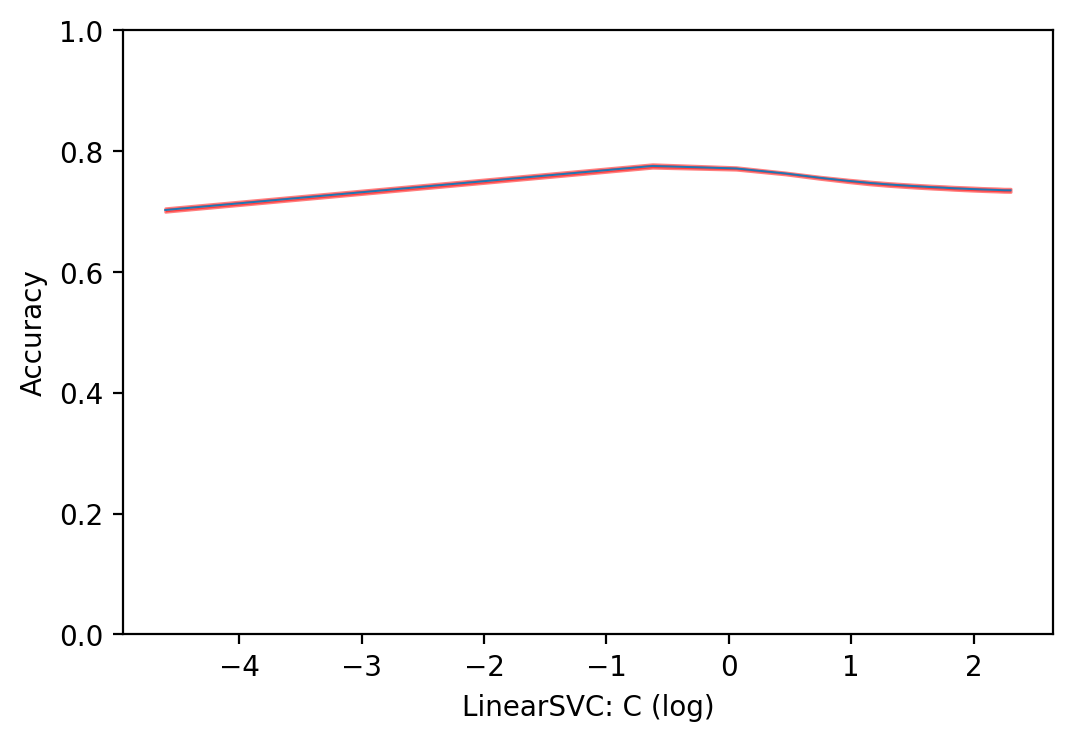

In [168]:
def plot_sensetivity_curve(df, parameter_name):
  x = np.log(df.iloc[:, 0].values)
  y = df.iloc[:, 1:].values
  y_means = np.zeros(x.shape[0])
  ci_lows = np.zeros(x.shape[0])
  ci_highs = np.zeros(x.shape[0])

  for i in range(x.shape[0]):
    y_mean = np.mean(y[i])
    y_means[i] = y_mean
    ci_low, ci_high = st.t.interval(alpha=0.95, df=y[i].shape[0]-1, loc=y_mean, scale=st.sem(y[i]))
    ci_lows[i] = ci_low
    ci_highs[i] = ci_high

  plt.figure(dpi=200)
  plt.plot(x, y_means, linewidth=.7)
  plt.fill_between(x, ci_lows, ci_highs, color='r', alpha=0.5, facecolor=None)
  plt.ylim(0, 1)
  plt.ylabel('Accuracy')
  plt.xlabel(f'{parameter_name} (log)')

plot_sensetivity_curve(df_cv_C, parameter_name='LinearSVC: C')

In [ ]:
min_df_rng = np.linspace(.01, .9, 15)
skfold = StratifiedKFold(n_splits=10)
columns=['min_df'] + [f'fold_{i}' for i in range(1, 11)]
df_cv_min_df = pd.DataFrame(columns=columns)

for min_df in min_df_rng:
  clf = build_pipeline(clf_kwargs=dict(penalty='l1', C=.5, dual=False, random_state=99), tfidf_kwargs=dict(min_df=min_df, ngram_range=(1, 3)), kbins_kwargs={'n_bins':4})
  cv_scores = cross_val_score(clf, df_sample, df_sample.label, n_jobs=-1, cv=skfold, scoring='roc_auc')
  df_cv_min_df = df_cv_min_df.append(pd.DataFrame([[min_df] + list(cv_scores)], columns=columns))

df_cv_min_df.head(2)

In [173]:
# df_cv_min_df.to_csv('/content/drive/MyDrive/milestone-ii/df_cv_min_df.csv', sep='\t')

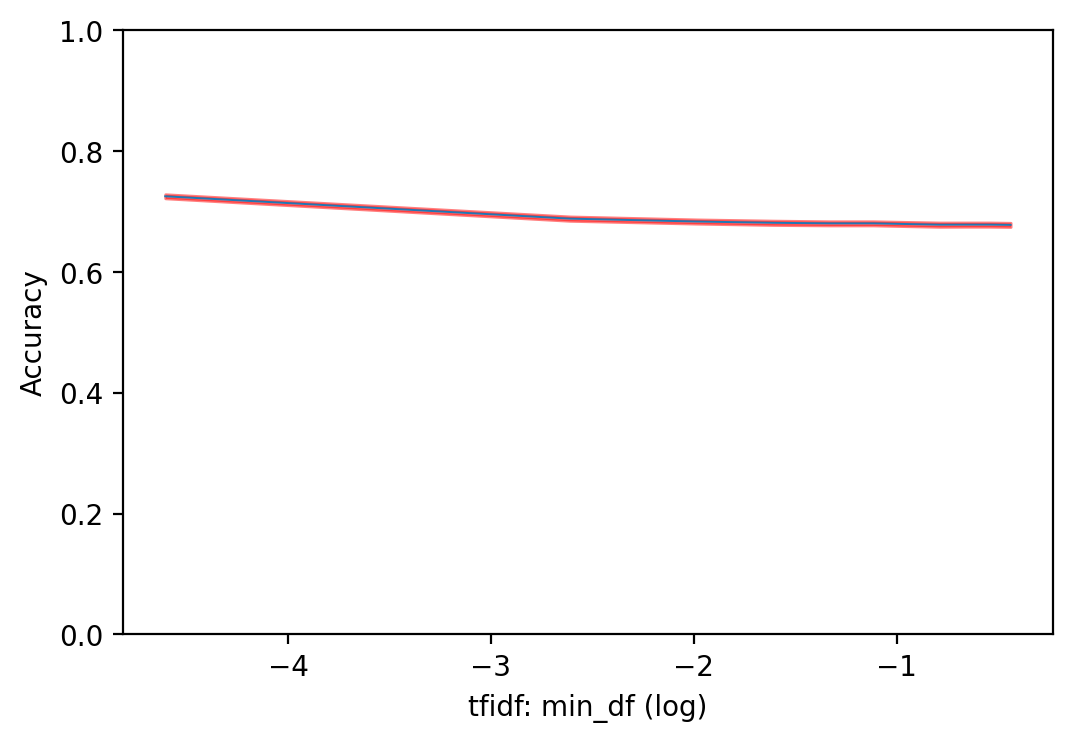

In [170]:
plot_sensetivity_curve(df_cv_min_df, parameter_name='tfidf: min_df')

In [ ]:
C_rng = np.linspace(.01, 10, 10)
min_df_rng = np.linspace(.01, .7, 10)
skfold = StratifiedKFold(n_splits=10)
columns=['C', 'min_df'] + [f'fold_{i}' for i in range(1, 11)]
df_cv_cp = pd.DataFrame(columns=columns)

for C, min_df in [(C, min_df) for C in C_rng for min_df in min_df_rng]:
  clf = build_pipeline(clf_kwargs=dict(penalty='l1', C=C, dual=False, random_state=99), tfidf_kwargs=dict(min_df=min_df, ngram_range=(1, 3)), kbins_kwargs={'n_bins':4})
  cv_scores = cross_val_score(clf, df_sample, df_sample.label, n_jobs=-1, cv=skfold, scoring='roc_auc')
  df_cv_cp = df_cv_cp.append(pd.DataFrame([[C, min_df] + list(cv_scores)], columns=columns))

df_cv_cp.head(2)

In [176]:
# df_cv_cp.to_csv('/content/drive/MyDrive/milestone-ii/df_cv_cp.csv', sep='\t')

In [177]:
df_cv_cp

,C,min_df,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
0,0.01,0.010000,0.719064,0.714770,0.711530,0.715812,0.720153,0.716069,0.721388,0.717015,0.723564,0.709450
0,0.01,0.086667,0.690212,0.685445,0.683332,0.690455,0.688820,0.684759,0.690864,0.688032,0.699057,0.681321
0,0.01,0.163333,0.684174,0.678528,0.676027,0.685714,0.682593,0.678403,0.683509,0.681874,0.691390,0.674077
0,0.01,0.240000,0.683911,0.677544,0.674717,0.685508,0.680953,0.678111,0.682174,0.679773,0.689480,0.673850
0,0.01,0.316667,0.683911,0.677544,0.674717,0.685508,0.680953,0.678111,0.682174,0.679773,0.689480,0.673850
...,...,...,...,...,...,...,...,...,...,...,...,...
0,10.00,0.393333,0.682571,0.676129,0.673255,0.684735,0.679908,0.677261,0.680945,0.678086,0.688418,0.672643
0,10.00,0.470000,0.680614,0.676099,0.672333,0.684665,0.679368,0.676781,0.679484,0.677555,0.687178,0.671147
0,10.00,0.546667,0.680614,0.676099,0.672333,0.684665,0.679368,0.676781,0.679484,0.677555,0.687178,0.671147
0,10.00,0.623333,0.680614,0.676099,0.672333,0.684665,0.679368,0.676781,0.679484,0.677555,0.687178,0.671147
